<a href="https://colab.research.google.com/github/saidnaqwe/Web-Analytics-Data620/blob/main/Project_2_Said_Naqwe_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data 620 Web Analytics

Project 2

Said Naqwe

**Introduction**

For my project, I dug into the "Large-scale Multi-layer Academic Networks (LMANStat)" dataset—a treasure trove of academic info! It’s got two Excel files packed with details on authors and papers, like names, institutions, regions, and research interests, plus eight CSV files covering edge lists for things like collaboration, citations, and keyword co-occurrence. I decided to zoom in on the author-to-paper edge list to see what patterns I could uncover in this academic web.
Analyzing big networks can get messy, so I turned to the island method to make sense of it. This approach helped me spot clusters of connections, showing how often authors teamed up on papers. At the lowest threshold, I found the most connections—tons of links between authors and papers—but it also showed the network isn’t super tight-knit overall. It was cool to see those authorship trends pop out, even if the bigger picture isn’t one giant, interconnected blob!


In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite as bi


**Data**

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/Gaotianchen97/LMANStat/main/Edgelist_author_paper_network.csv")

In [5]:
df

,Target,Source,Year
0,Paper_1,Author_50203,2000
1,Paper_2,Author_33399,2000
2,Paper_2,Author_29791,2000
3,Paper_3,Author_24663,2000
4,Paper_4,Author_43104,2000
...,...,...,...
217769,Paper_97434,Author_53211,2012
217770,Paper_97435,Author_39993,2010
217771,Paper_97435,Author_10595,2010
217772,Paper_97435,Author_70265,2010


In [6]:
paper = pd.DataFrame(df.Target.unique(),columns = ['Paper'])
author = pd.DataFrame(df.Source.unique(),columns = ['Author'])

In [7]:
paper_list = paper['Paper'].to_list()

In [8]:
author_list = author['Author'].to_list()

With the sets created, I will now construct the bipartite graph using the add_nodes_from() function in the NetworkX library.



In [9]:
G = nx.Graph() #create an empty graph
G.add_nodes_from(author_list, bipartite = "authors")
G.add_nodes_from(paper_list, bipartite = "papers")

By inspecting the nodes of the graph with the data=True argument, we can observe the partition being stored.

In [10]:
edges = df[['Target','Source']]

In [11]:
edges_tuple = [tuple(i) for i in edges.values]

In [12]:
G.add_edges_from(edges_tuple)

**Graphing the Data**

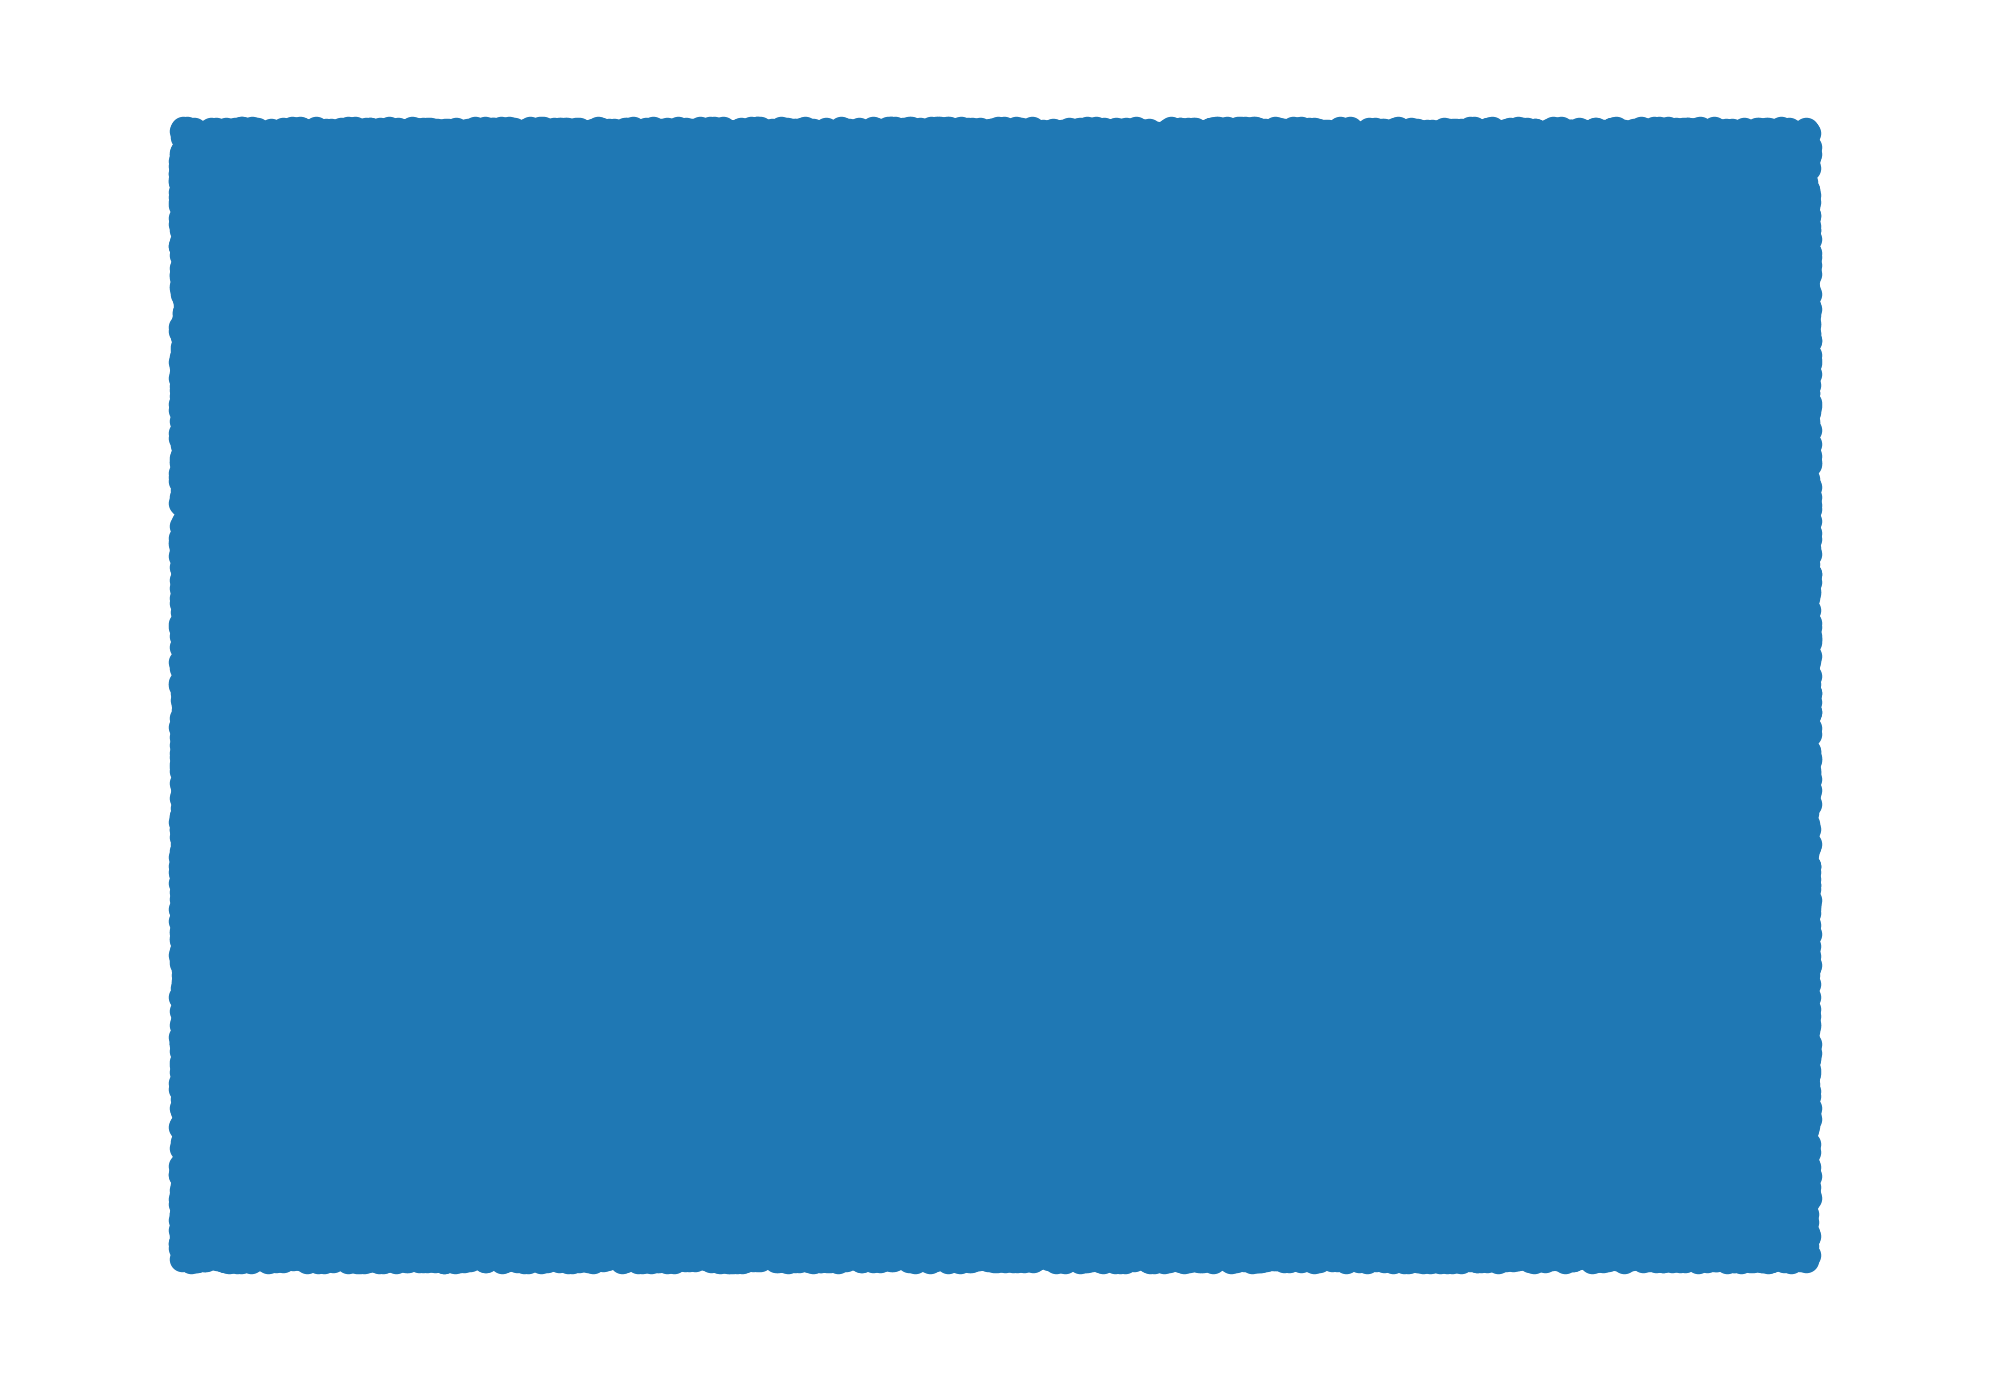

In [13]:
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(G)
nx.draw_networkx_edges(G,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(G, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

In [14]:
nx.is_bipartite(G)

True

When visualizing the bipartite graph, the network appears dense. Without further manipulation, it is challenging to derive meaningful insights from this plot alone.

**Implementing the Island Method**

To extract valuable information from a large network, I employed the island method. This technique generates subgraphs and connections based on node weights.

In [15]:
#Code sourced from the Social Network Analysis for Startups 2021 edition
def trim_edges(g, weight=1):
  g2=nx.Graph()
  for f, to, edata in g.edges(data=True):
    if edata['weight'] > weight:
      g2.add_edge(f,to,weight = edata)
  return g2

In [16]:
#Code sourced from the Social Network Analysis for Startupds 2021 edition
def island_method(g, iterations=5):
  weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
  mn=int(min(weights))
  mx=int(max(weights))
  #compute the size of the step, so we get a reasonable step in iterations
  step=int((mx-mn)/iterations)
  return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

**Using the Island Method**

The G network is not fully connected. However, there are 7,893 connected subgraphs within this network that could provide further insights.

In [17]:
nx.is_connected(G)

False

In [18]:
##[len(c) for c in nx.connected_component_subgraphs(G) if len(c) > 10]
A = (G.subgraph(c) for c in nx.connected_components(G))
len(list(A))


7893

To apply the island method described above, I created two bipartite weighted graphs using the weighted_projected_graph() function.

The list below shows the weight, or the number of connections, between each author. This graph highlights authors who collaborated on at least one paper.

**Author's Island**

By projecting the graph to include only author nodes, I can draw more accurate conclusions from the data.

In [19]:
author_nodes = [a for a,d in G.nodes(data=True) if d['bipartite'] == 'authors']
weighted_author_graph = bi.weighted_projected_graph(G, author_nodes)
list(weighted_author_graph.edges(data=True))[0:10]

[('Author_50203', 'Author_69437', {'weight': 1}),
 ('Author_50203', 'Author_13826', {'weight': 7}),
 ('Author_50203', 'Author_2990', {'weight': 2}),
 ('Author_50203', 'Author_65428', {'weight': 1}),
 ('Author_50203', 'Author_57771', {'weight': 3}),
 ('Author_50203', 'Author_4940', {'weight': 1}),
 ('Author_50203', 'Author_56358', {'weight': 1}),
 ('Author_50203', 'Author_25102', {'weight': 1}),
 ('Author_50203', 'Author_41807', {'weight': 1}),
 ('Author_33399', 'Author_29791', {'weight': 1})]

Using the triangles functions, I can see the how many authors are clustered in triangles.

In [20]:
dict((list(nx.triangles(weighted_author_graph).items()))[0:10])

{'Author_50203': 4,
 'Author_33399': 0,
 'Author_29791': 14,
 'Author_24663': 80,
 'Author_43104': 1,
 'Author_6604': 38,
 'Author_19828': 2,
 'Author_5644': 187,
 'Author_52804': 0,
 'Author_1968': 13}

In [21]:
len(list(nx.connected_components(weighted_author_graph)))

7893

The number of connected components, or authors linked at least once, is 7,893. This indicates that there are 7,893 networks of authors who collaborated on a paper together within this network.

Below is a preview of the degree centrality for the author nodes.



In [22]:
dict((list(nx.degree_centrality(weighted_author_graph).items()))[0:10])

{'Author_50203': 0.000127237255068284,
 'Author_33399': 1.4137472785364888e-05,
 'Author_29791': 0.0004241241835609466,
 'Author_24663': 0.0008058359487657986,
 'Author_43104': 2.8274945570729776e-05,
 'Author_6604': 0.00040998671077558177,
 'Author_19828': 5.654989114145955e-05,
 'Author_5644': 0.0013289224418242995,
 'Author_52804': 1.4137472785364888e-05,
 'Author_1968': 0.000254474510136568}

In [23]:
[len(c) for c in nx.connected_components(weighted_author_graph) if len(c) > 10][0:10]

[54112, 17, 15, 12, 14, 19, 11, 13, 12, 15]

Furthermore, the author's graph is not fully connected, indicating the absence of a single paper on which all authors collaborated.

By employing list comprehension, I can identify the various connected components within the graph. The largest connected component comprises 54,112 nodes.

Notably, there is one giant component with over 54,000 nodes. According to the textbook, this giant component can be considered representative of the entire network. It is the first component listed when using the connected_components function.

In [24]:
S = [weighted_author_graph.subgraph(c).copy() for c in nx.connected_components(weighted_author_graph)]

In [25]:
nx.is_connected(S[0])

True

Now I can use the island method on this connected component to analyze this large network closer.

In [26]:
island_authors = island_method(S[0])

In [27]:
for i in island_authors:
  print("Threshold:",i[0], "Size:",len(i[1]), "Connections:", len(list(nx.connected_components(i[1]))))


Threshold: 1 Size: 16667 Connections: 1250
Threshold: 13 Size: 304 Connections: 121
Threshold: 25 Size: 35 Connections: 16
Threshold: 37 Size: 10 Connections: 5
Threshold: 49 Size: 6 Connections: 3
Threshold: 61 Size: 2 Connections: 1


By using the island_method I was able to divide by 6 thresholds. This threshold can be specified in the function, but for this project I will keep it simple.

Next I created islands at the first threshold. The first threshold has 1,250 connections (also known as edges) and the graph's size was 16,667 nodes.

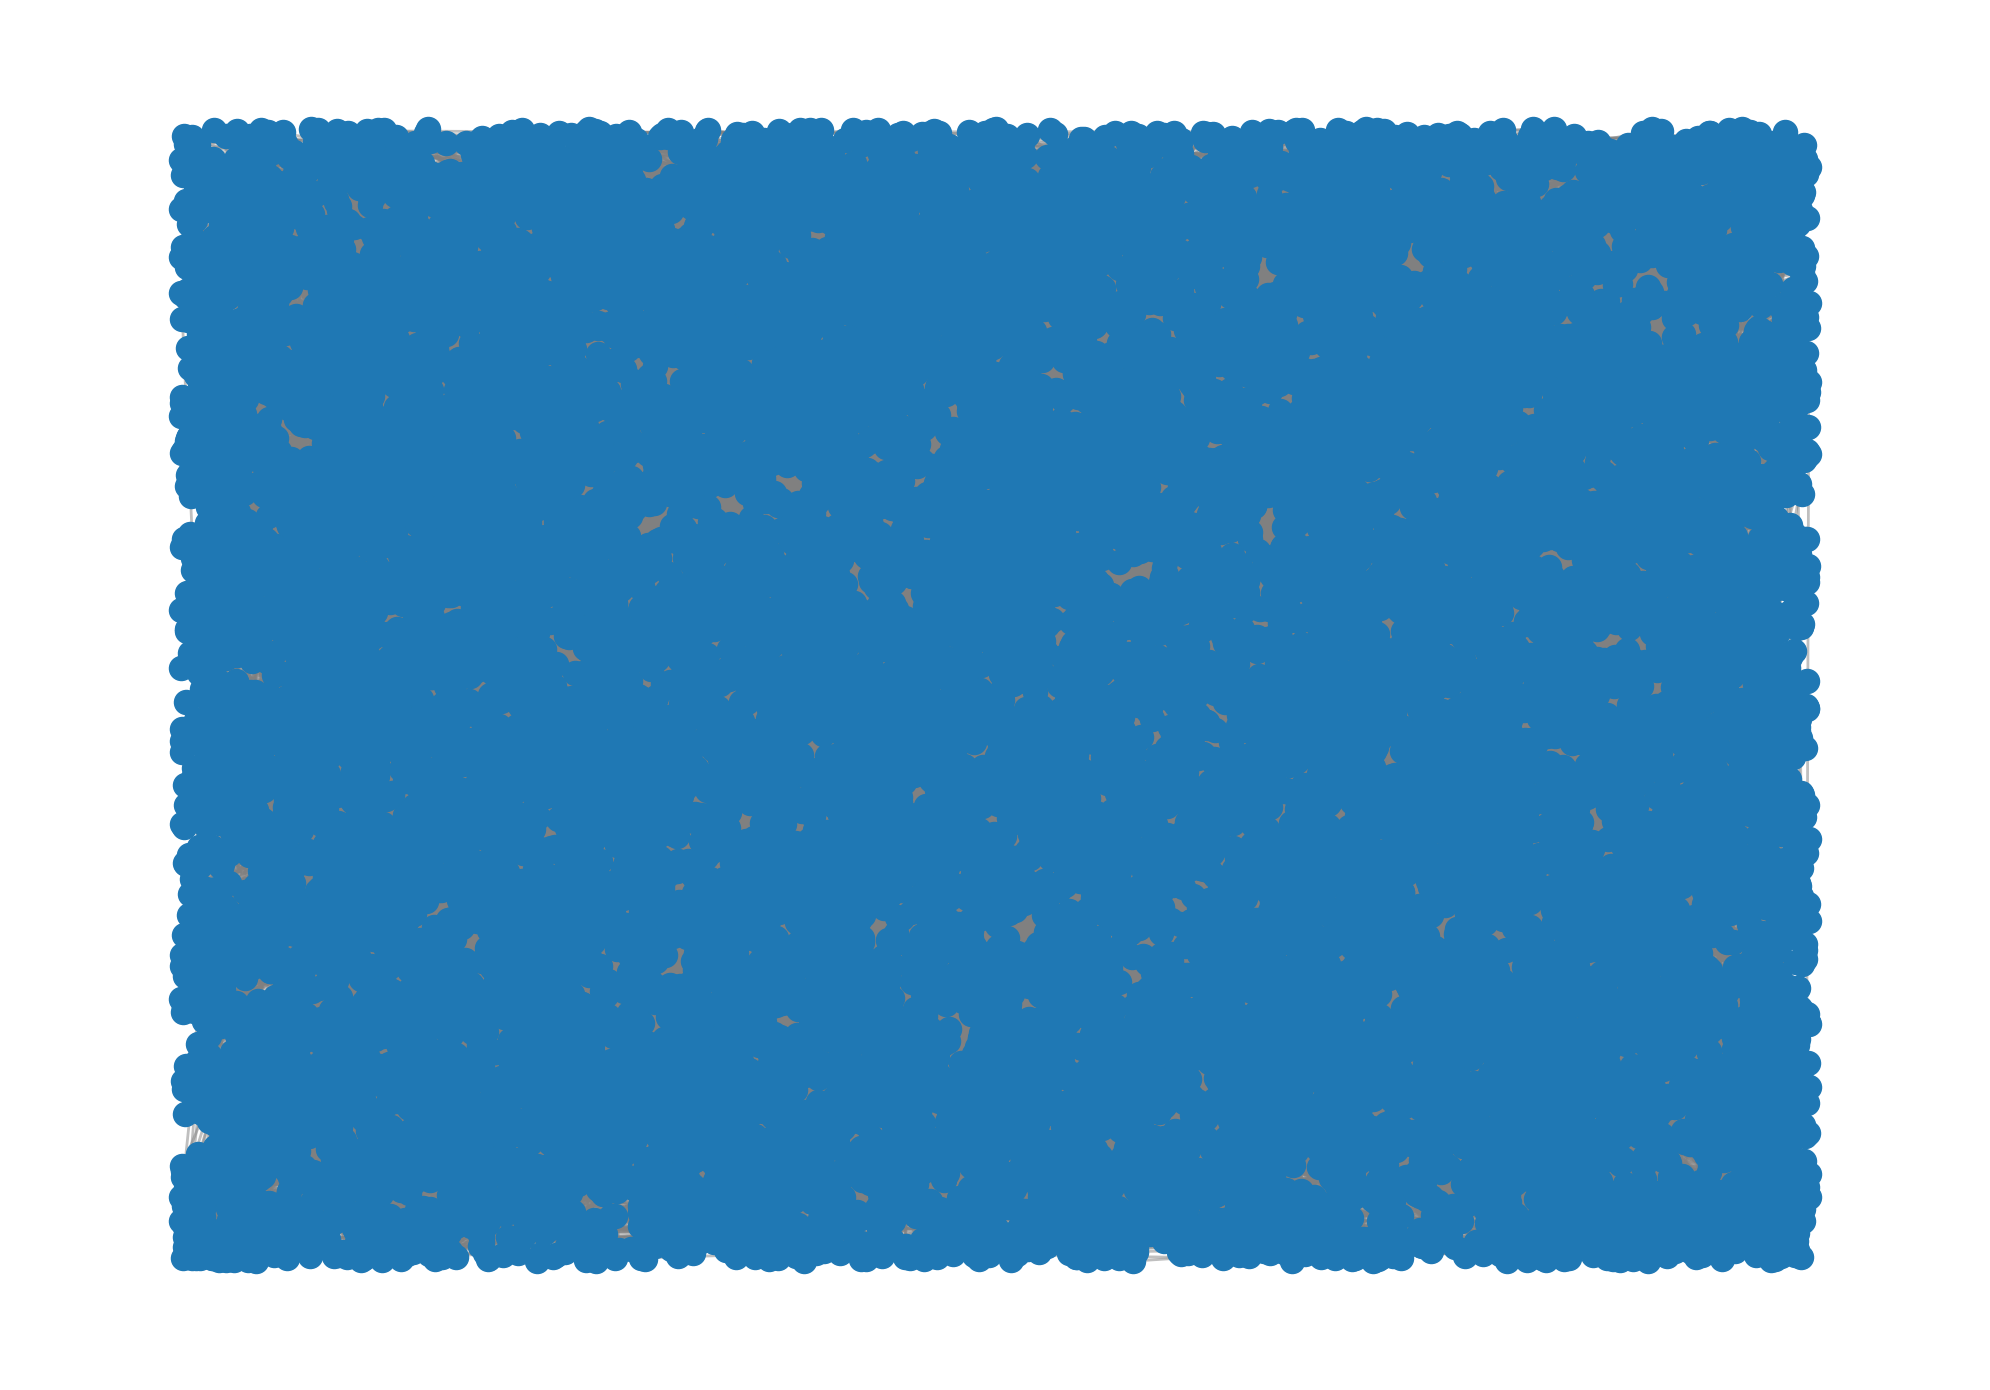

In [28]:
subgraph = island_authors[0][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

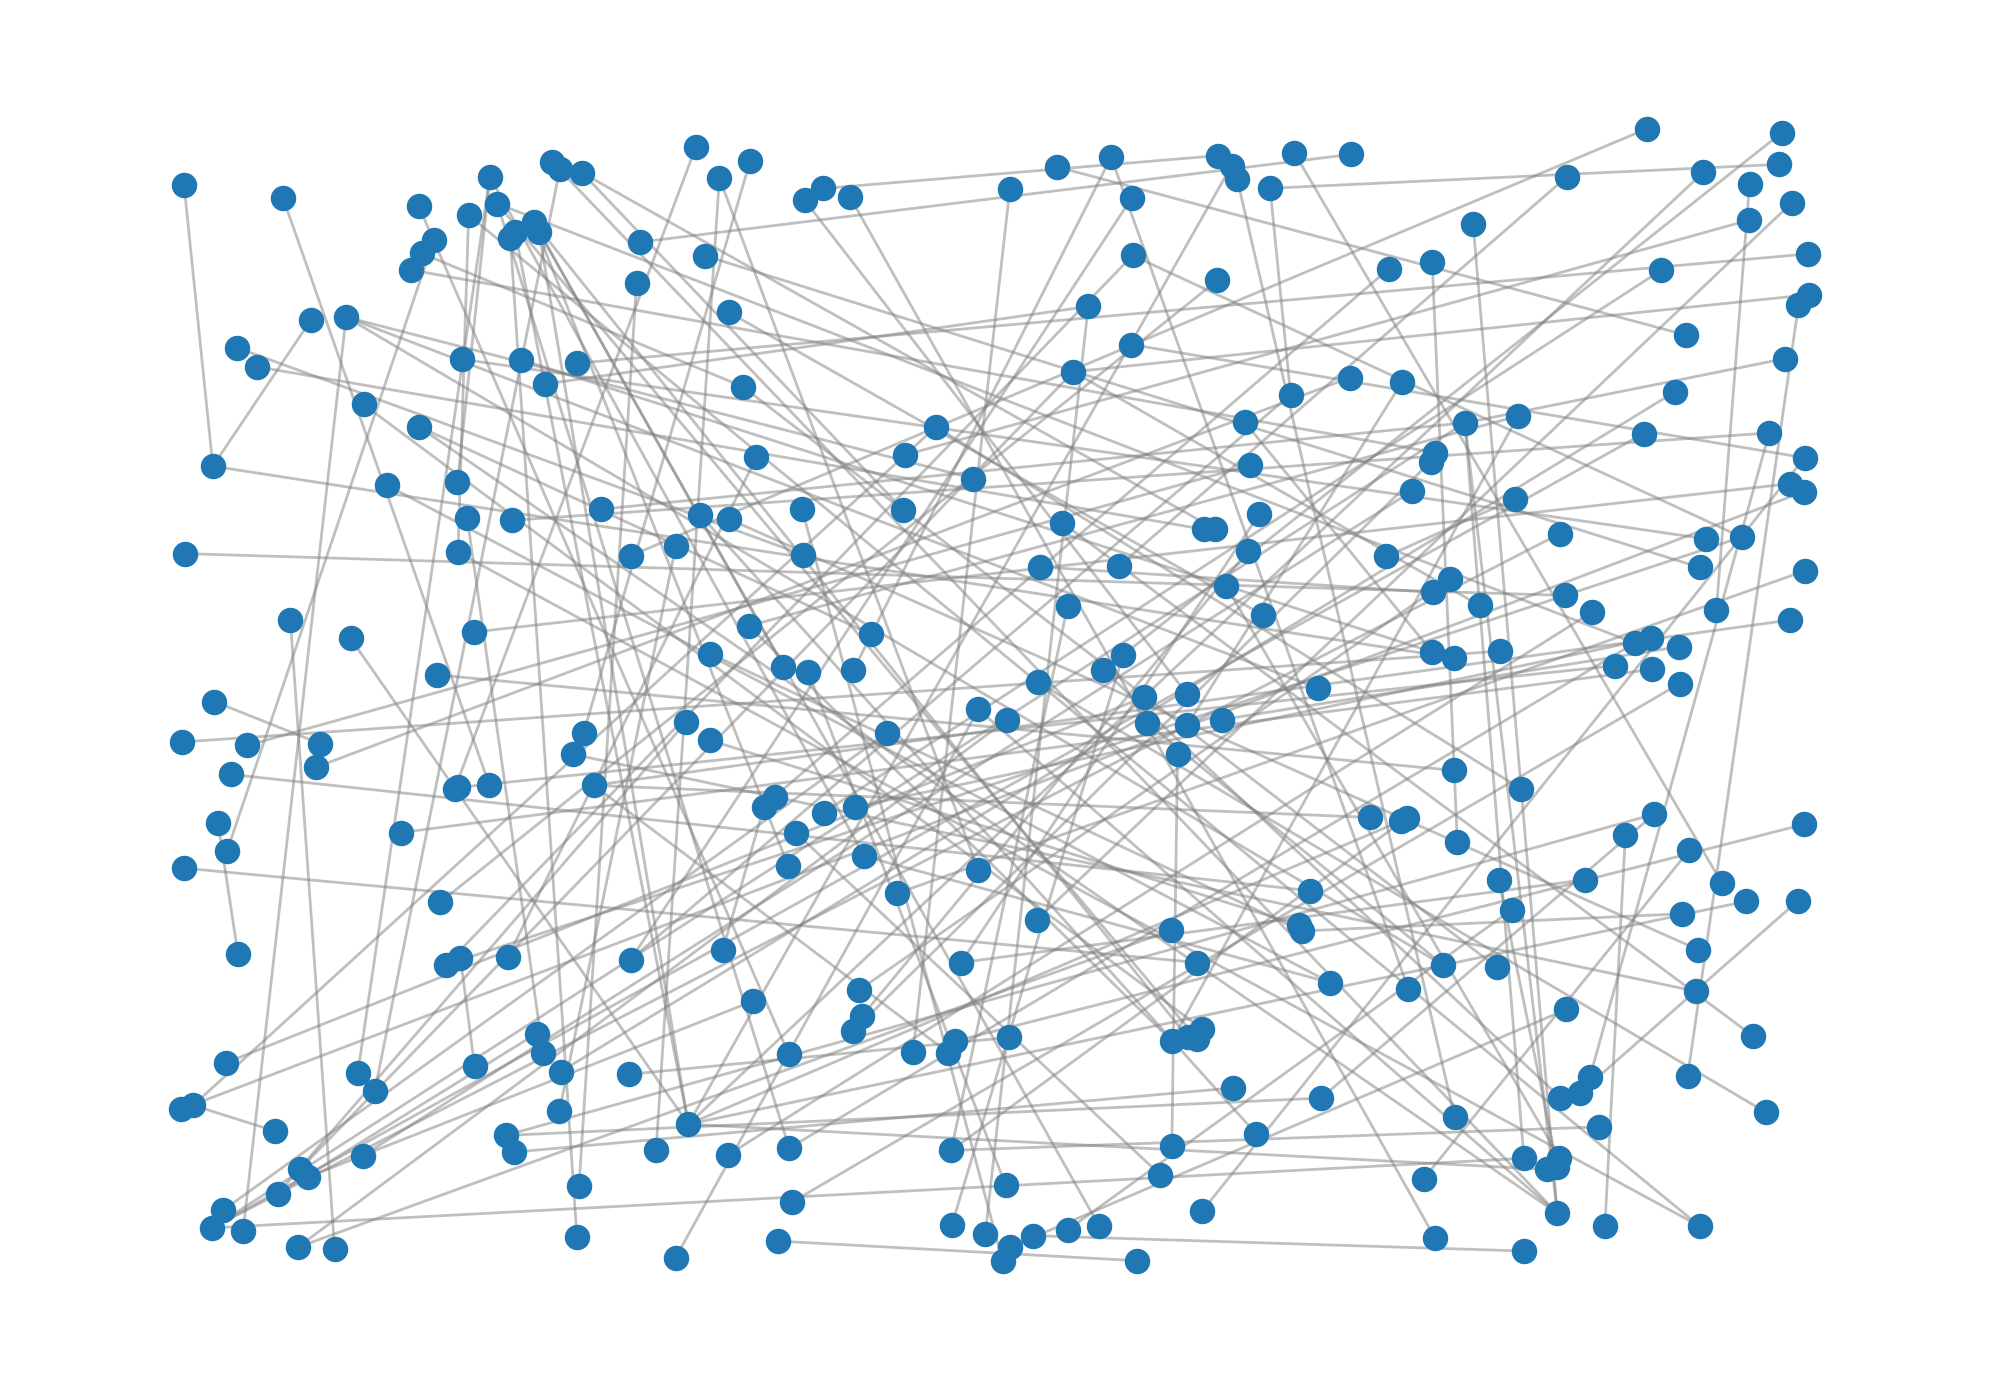

In [29]:
subgraph = island_authors[1][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

At the next threshold (as illustrated above), the graph becomes less dense. However, it remains insufficient for drawing any visual conclusions.

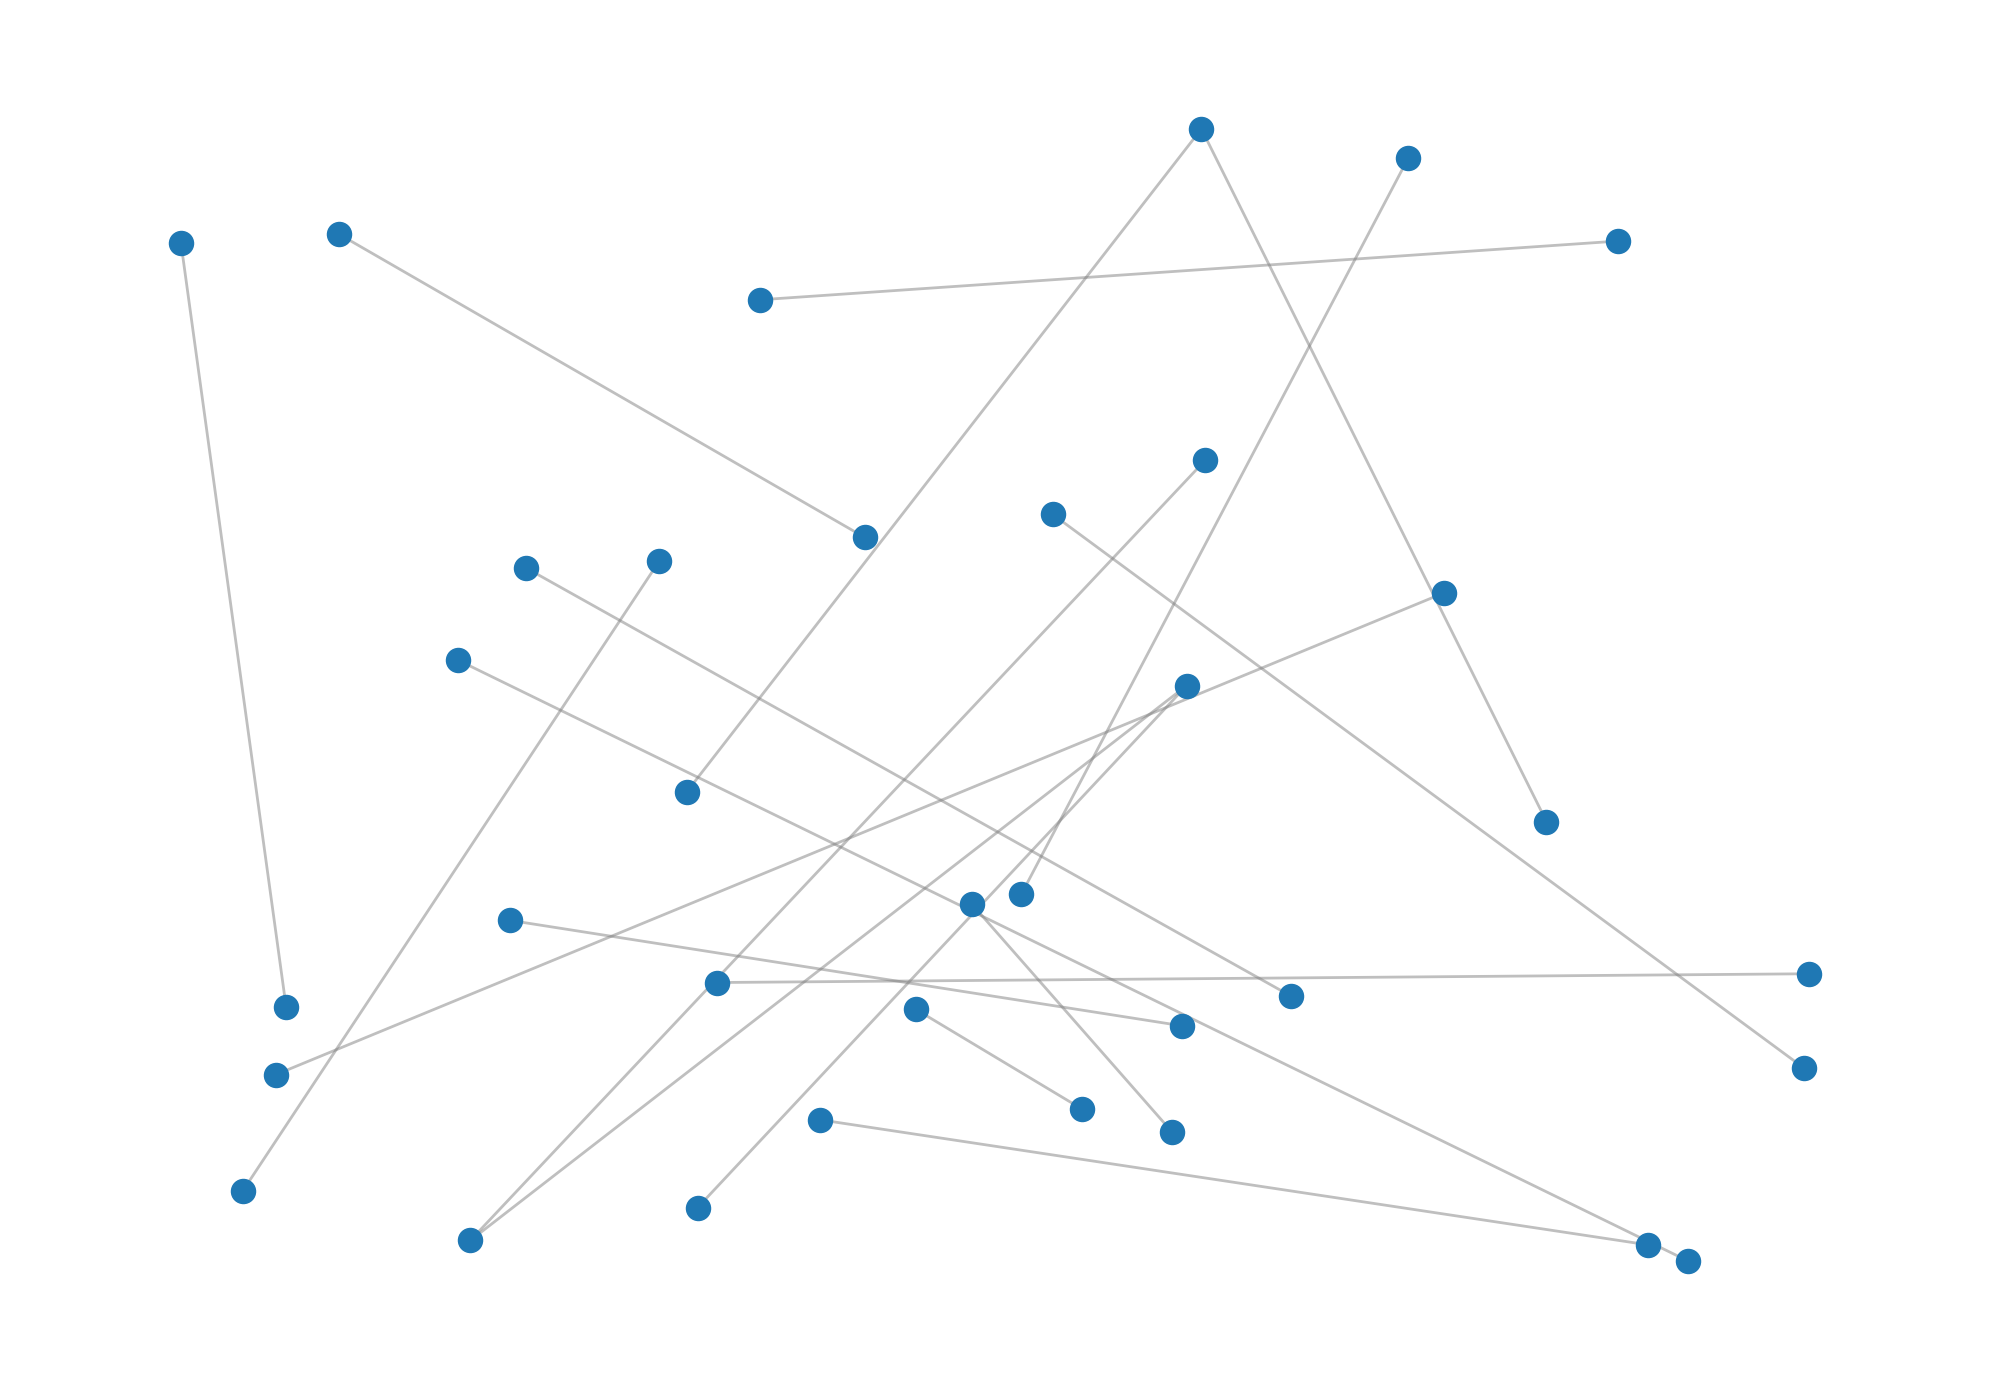

In [30]:
subgraph = island_authors[2][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()


At this threshold (as shown above), we can observe more of the islands and their connections, allowing for clearer visual conclusions. There are examples of islands with as many as four nodes and as few as two nodes.

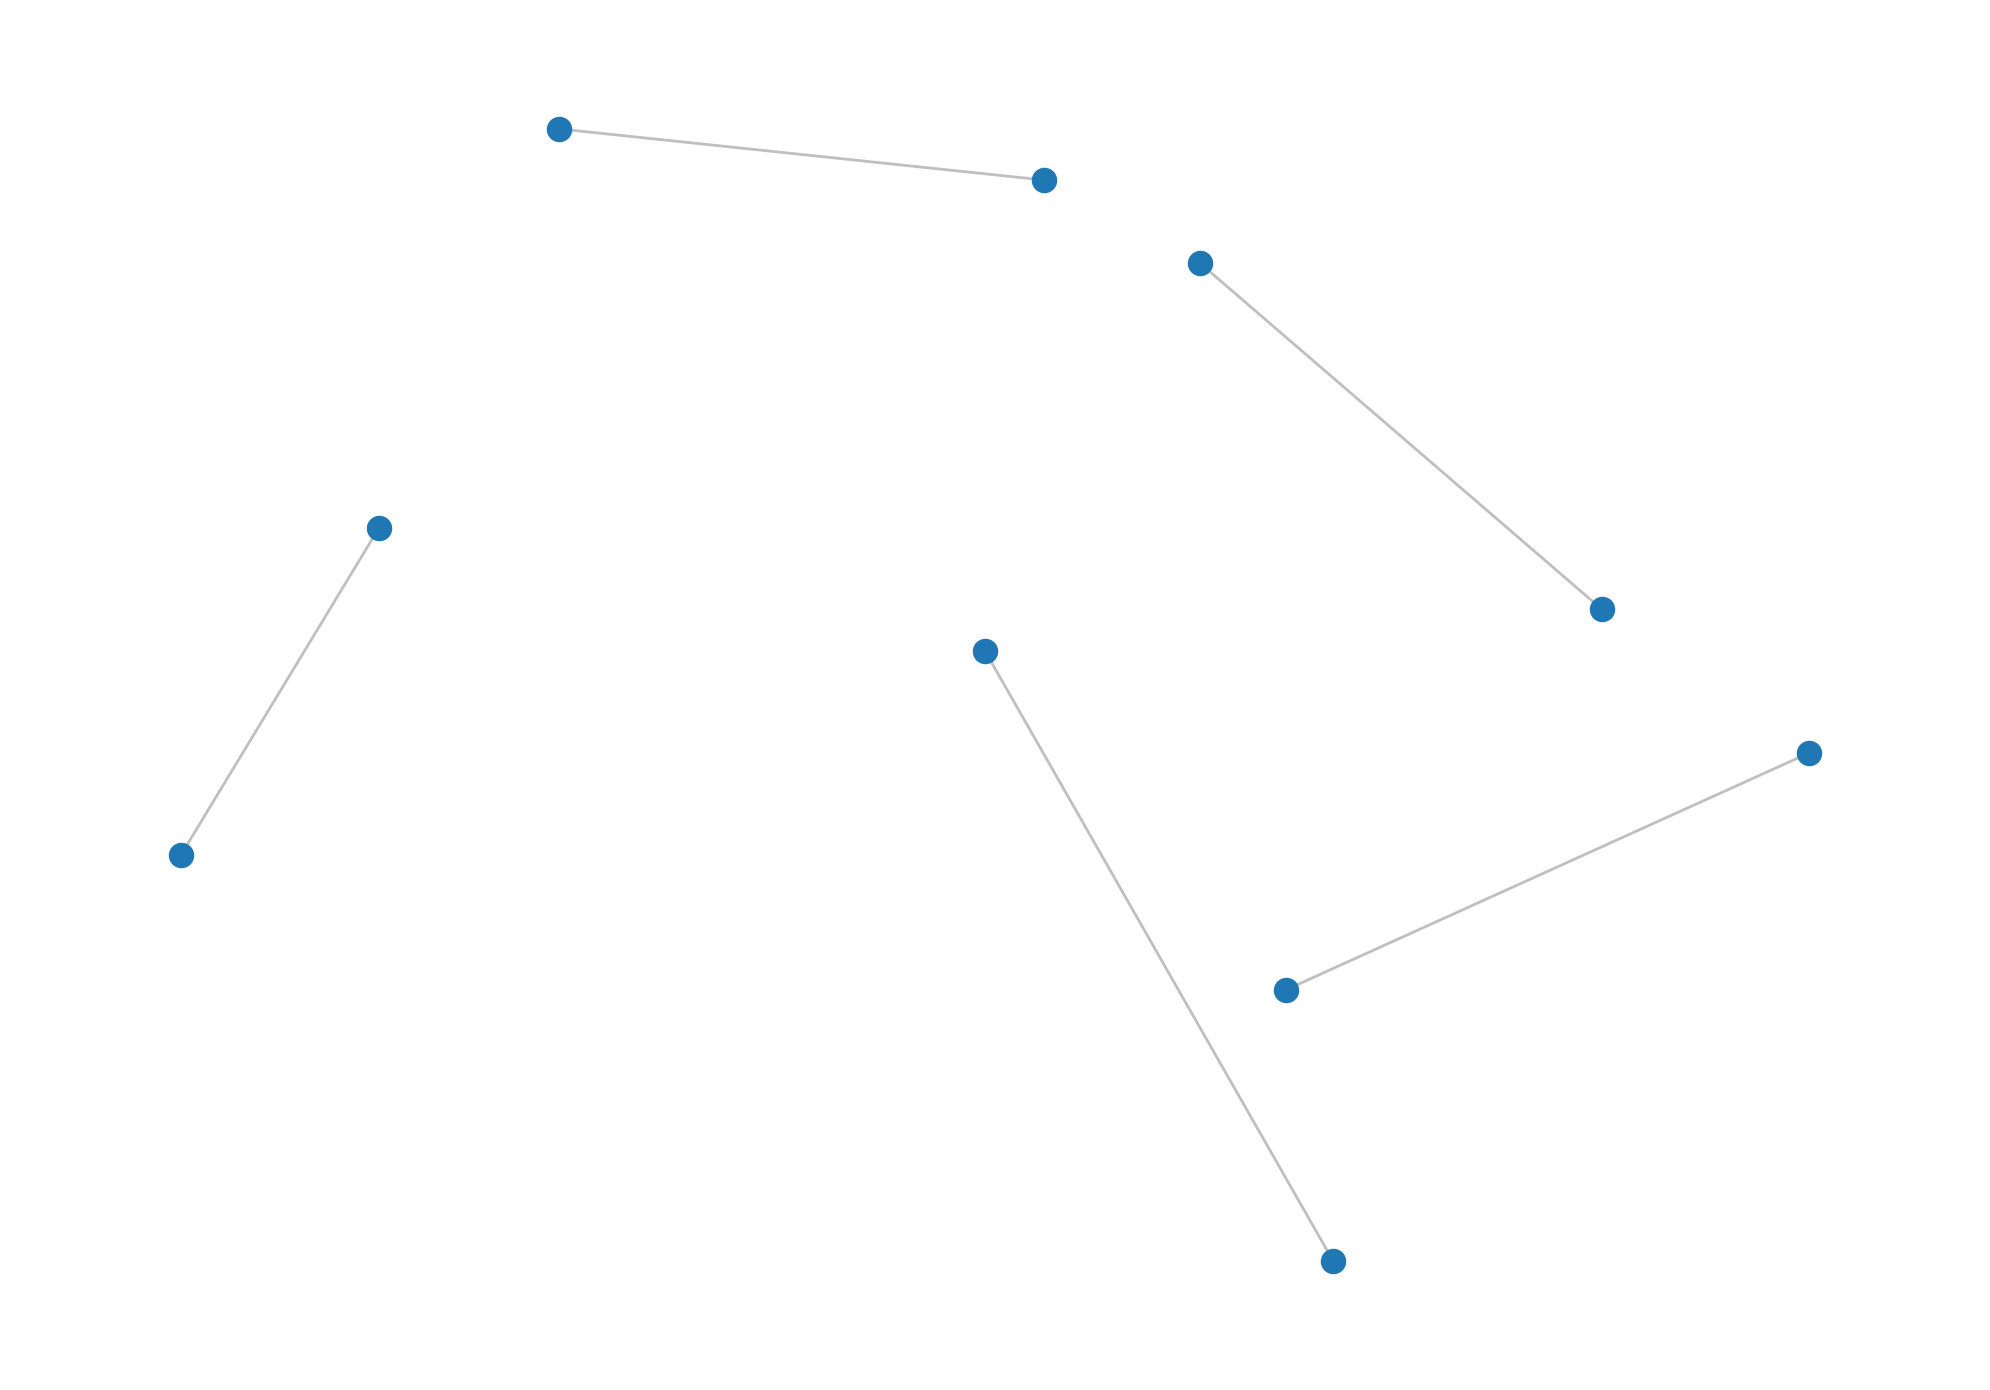

In [31]:
subgraph = island_authors[3][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

The higher the threshold, the less connections we can see between the author nodes. Here all of the islands have two nodes only.

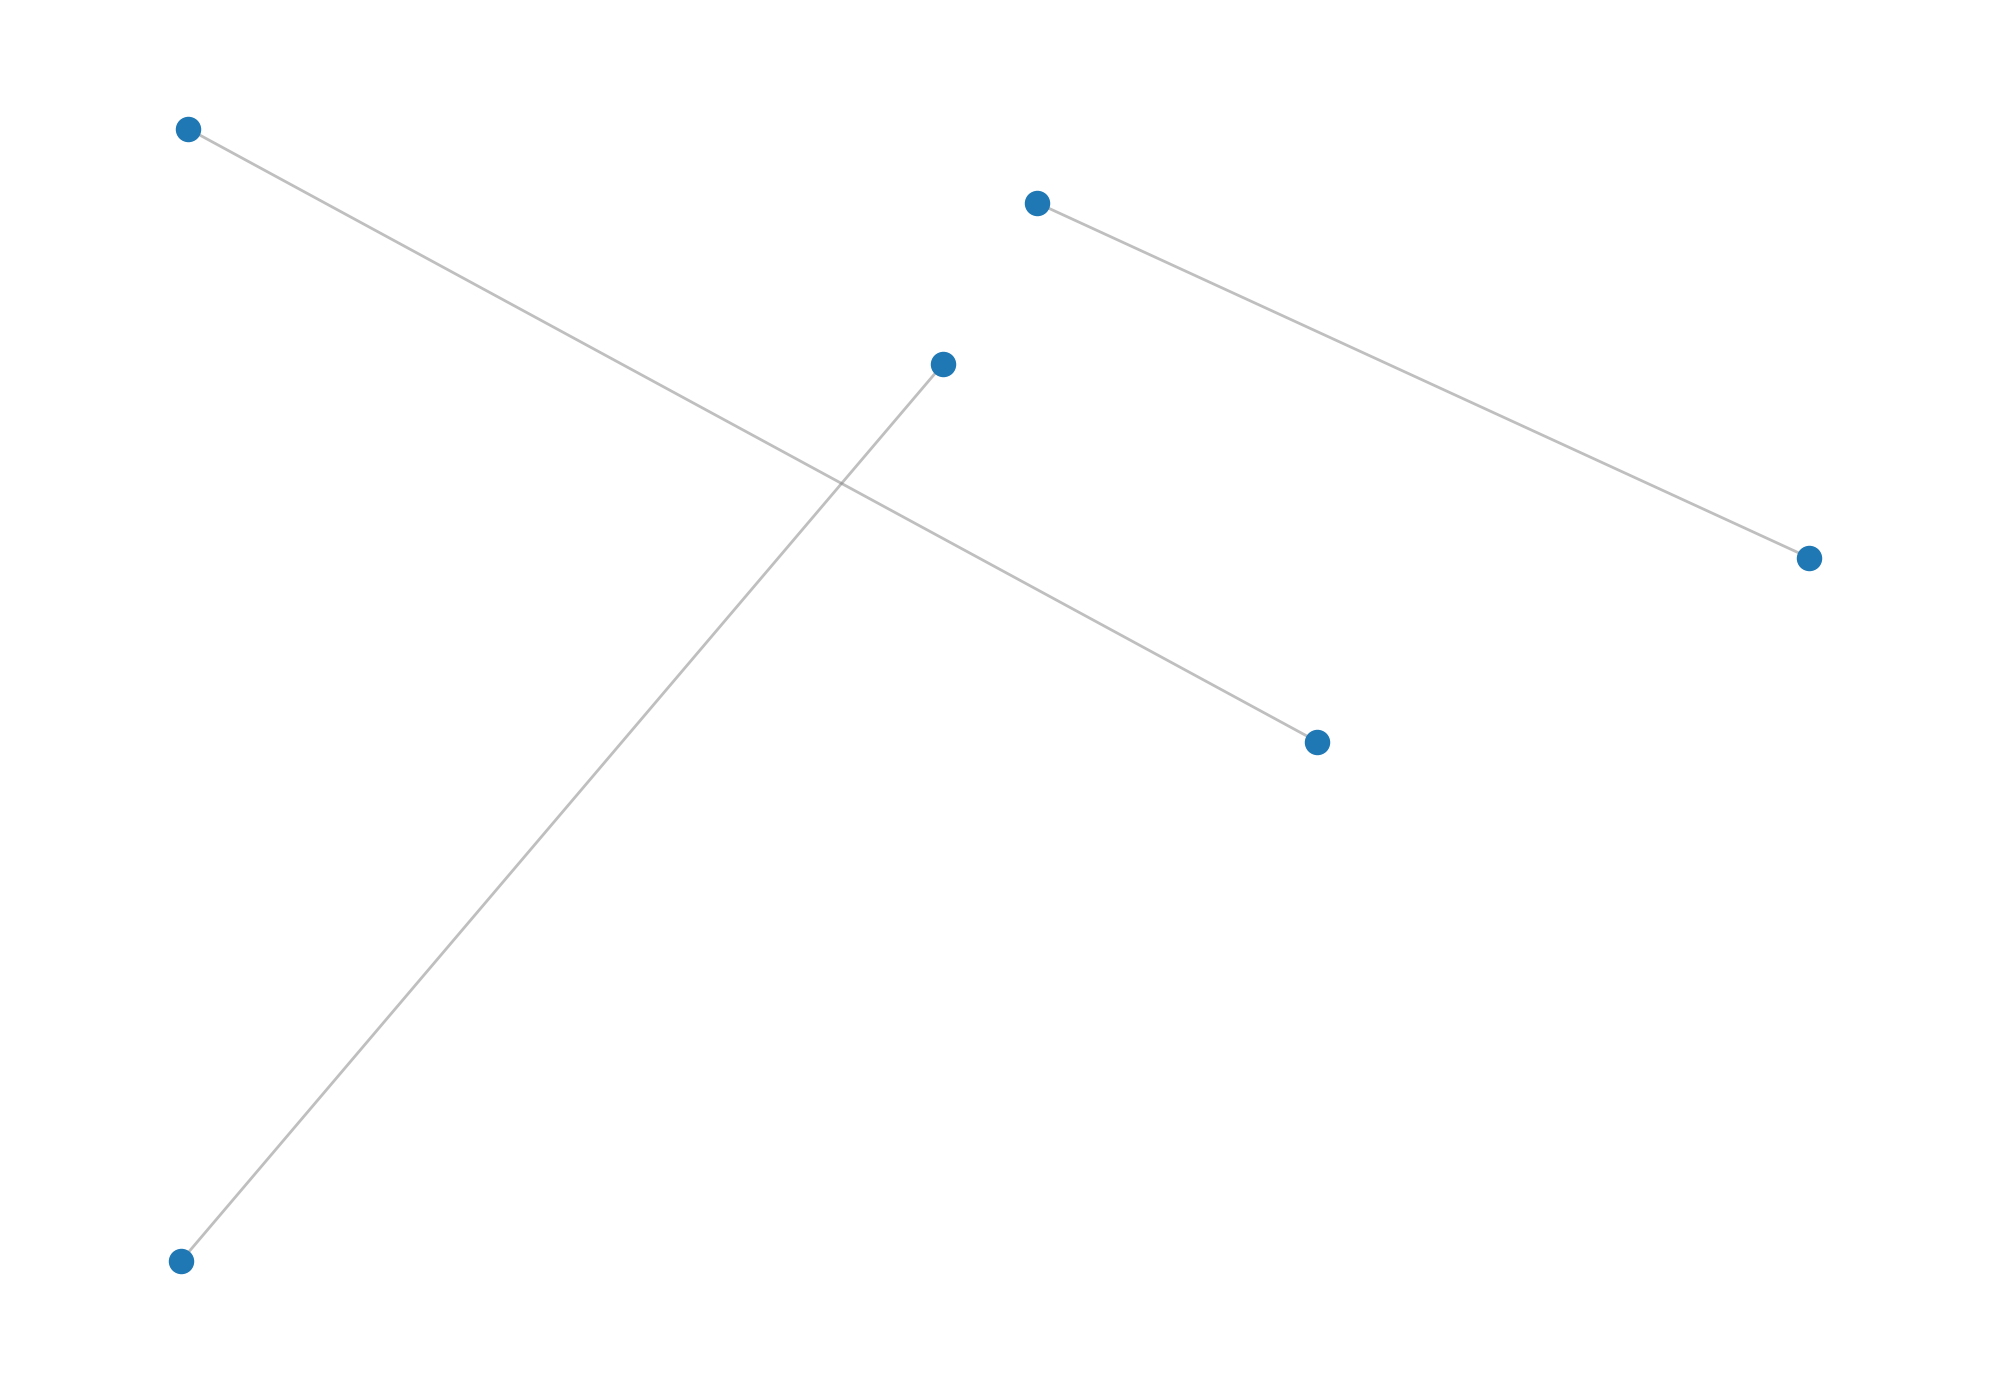

In [32]:
subgraph = island_authors[4][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()


This second to last threshold only shows two islands.

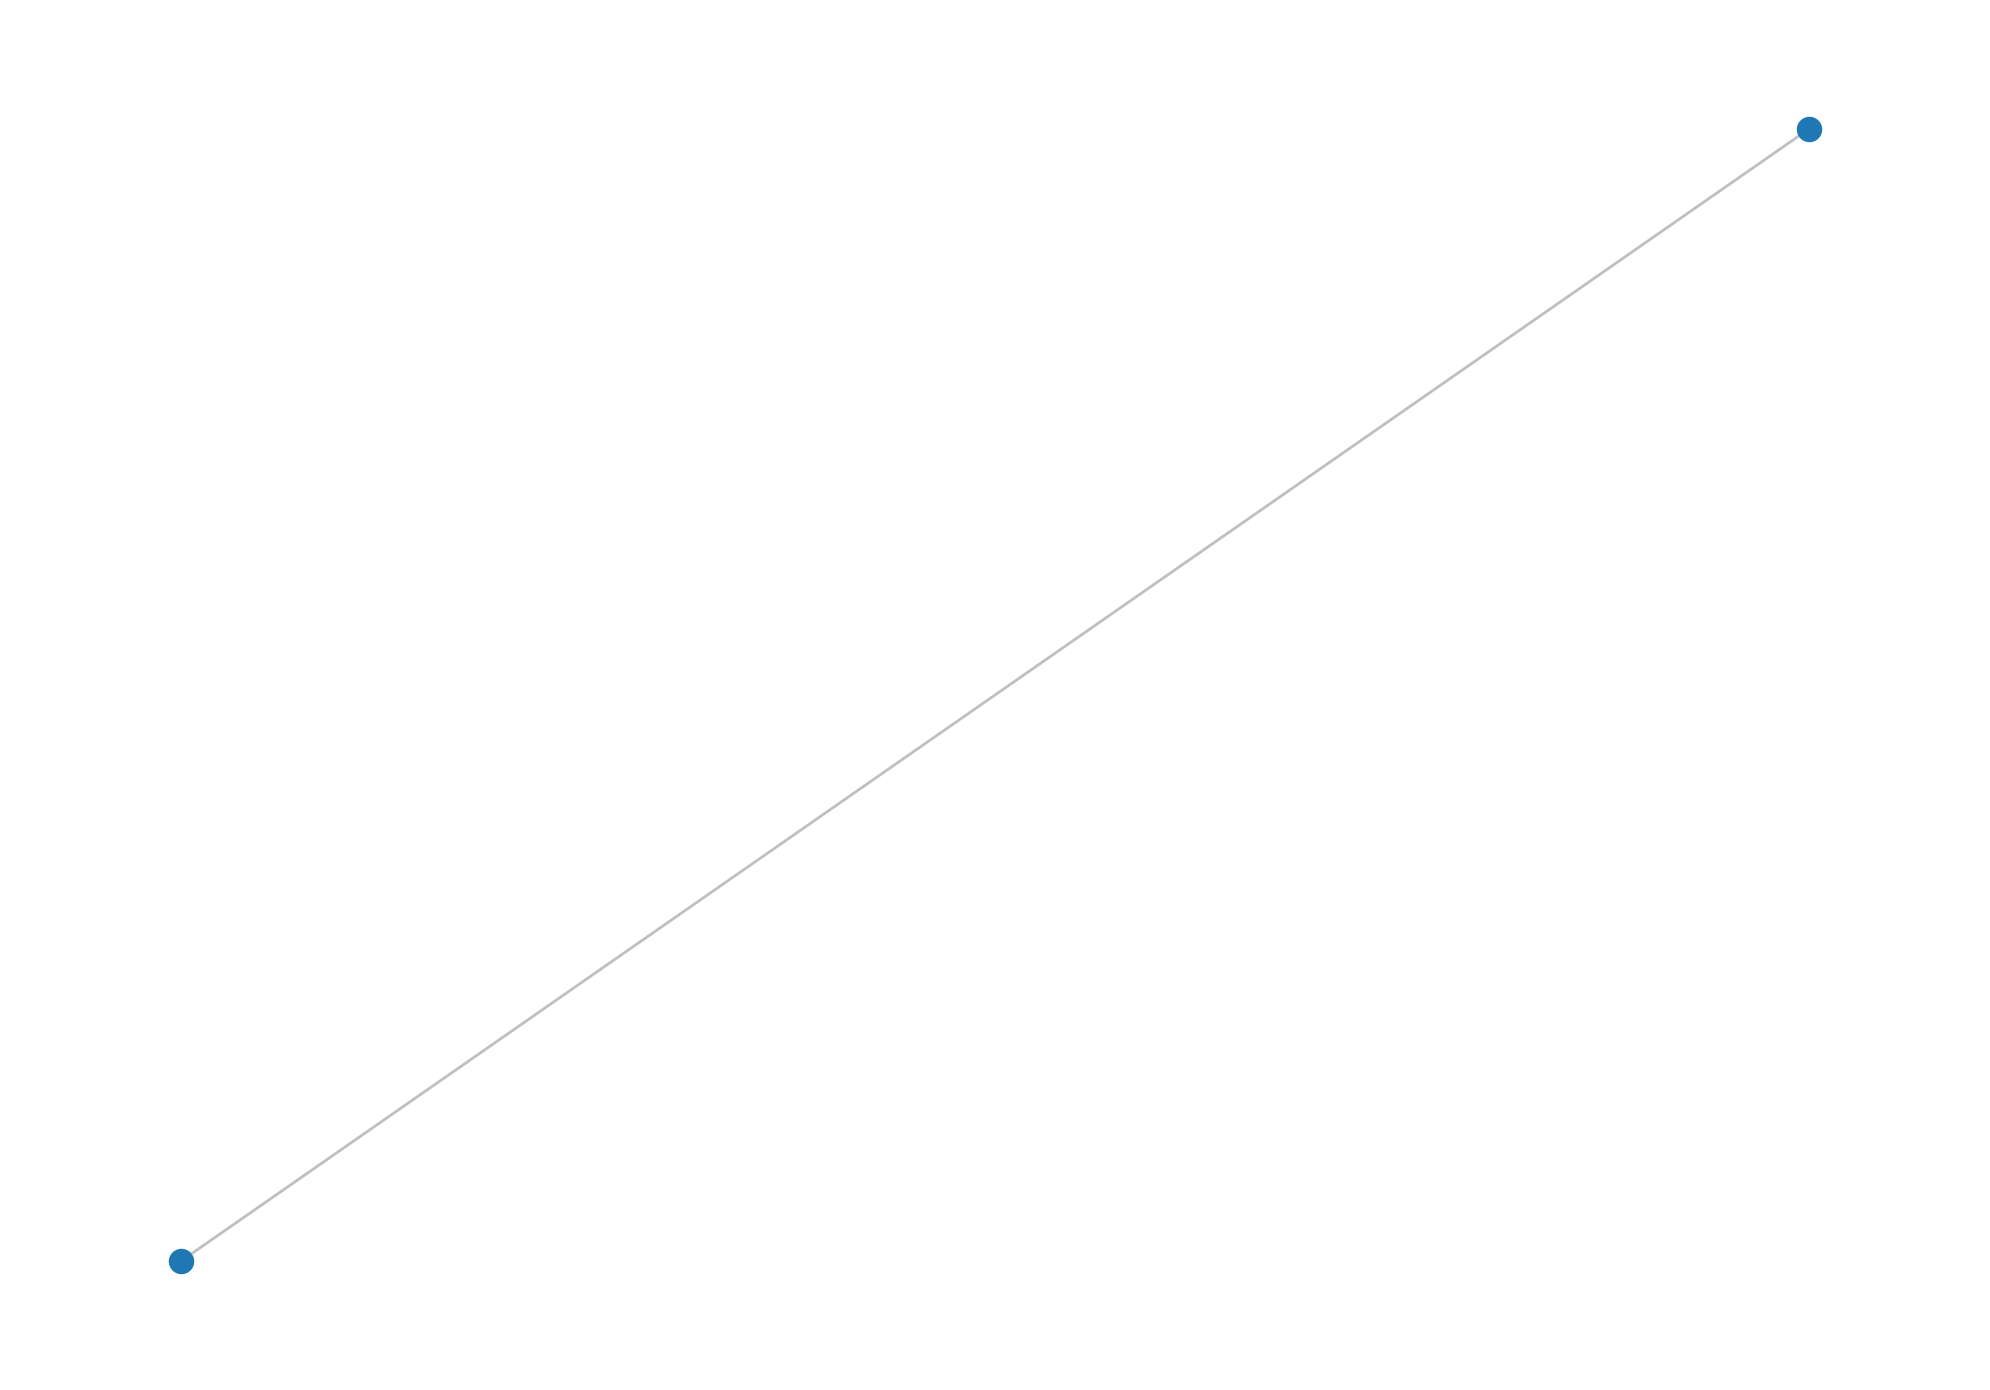

In [33]:
subgraph = island_authors[5][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

The island graph reveals that certain authors are connected through shared papers. The initial graph
G was too dense to visually discern any connections between authors. However, by employing the island method, these connections become clearer. This analysis indicates that the maximum number of authors connected to a single paper is 1,250 when the threshold weight is set to 1.

**Papers' Island**

Next, I will apply the same methodology used for the author nodes to the paper nodes.

In [34]:
paper_nodes = [a for a,d in G.nodes(data=True) if d['bipartite'] == 'papers']
weighted_paper_graph = bi.weighted_projected_graph(G, paper_nodes)
list(weighted_paper_graph.edges(data=True))[0:20]

[('Paper_1', 'Paper_23908', {'weight': 1}),
 ('Paper_1', 'Paper_8484', {'weight': 1}),
 ('Paper_1', 'Paper_43393', {'weight': 1}),
 ('Paper_1', 'Paper_65196', {'weight': 1}),
 ('Paper_1', 'Paper_62157', {'weight': 1}),
 ('Paper_1', 'Paper_44405', {'weight': 1}),
 ('Paper_1', 'Paper_16424', {'weight': 1}),
 ('Paper_1', 'Paper_24278', {'weight': 1}),
 ('Paper_1', 'Paper_79482', {'weight': 1}),
 ('Paper_1', 'Paper_38586', {'weight': 1}),
 ('Paper_1', 'Paper_10028', {'weight': 1}),
 ('Paper_1', 'Paper_44301', {'weight': 1}),
 ('Paper_1', 'Paper_39999', {'weight': 1}),
 ('Paper_1', 'Paper_63176', {'weight': 1}),
 ('Paper_1', 'Paper_39540', {'weight': 1}),
 ('Paper_1', 'Paper_77662', {'weight': 1}),
 ('Paper_1', 'Paper_42430', {'weight': 1}),
 ('Paper_1', 'Paper_42513', {'weight': 1}),
 ('Paper_1', 'Paper_40001', {'weight': 1}),
 ('Paper_1', 'Paper_50918', {'weight': 1})]

There are 7893 connected components in the weighted paper graph.

In [35]:
len(list(nx.connected_components(weighted_paper_graph)))

7893

In [37]:
paper_triangles = nx.triangles(weighted_paper_graph)

In [38]:
dict((list(paper_triangles.items()))[0:10])

{'Paper_1': 861,
 'Paper_2': 862,
 'Paper_3': 6786,
 'Paper_4': 383,
 'Paper_5': 6349,
 'Paper_6': 1,
 'Paper_7': 616,
 'Paper_8': 29,
 'Paper_9': 1821,
 'Paper_10': 55}

The weighted paper graph shows that there are triangles in this projections. The paper with the maximum amount of triangles it was apart of is Paper 8394.

In [39]:
max(paper_triangles, key= lambda x: paper_triangles[x])

'Paper_83294'

The degree centrality is saved to paper_dc.

In [40]:
paper_dc = nx.degree_centrality(weighted_paper_graph)

In [41]:
max(paper_dc, key= lambda x: paper_dc[x])

'Paper_83294'

The paper with the maximum degree centrality is again Paper 83294.

In [42]:
dict((list(paper_triangles.items()))[0:10])

{'Paper_1': 861,
 'Paper_2': 862,
 'Paper_3': 6786,
 'Paper_4': 383,
 'Paper_5': 6349,
 'Paper_6': 1,
 'Paper_7': 616,
 'Paper_8': 29,
 'Paper_9': 1821,
 'Paper_10': 55}

The degree centrality shows the importance of each nodes by the number of connections it has.

In [43]:
[len(c) for c in nx.connected_components(weighted_paper_graph) if len(c) > 10][0:10]

[84407, 18, 23, 19, 17, 18, 21, 16, 12, 11]

The largest connected subgraph has 88407 components in it.

In [44]:
S = [weighted_paper_graph.subgraph(c).copy() for c in nx.connected_components(weighted_paper_graph)]

Utilizing the island method with a threshold of 5, we show at least 6 different graphs below.

In [45]:
island_papers = island_method(S[0])

In [46]:
island_papers

[[1, <networkx.classes.graph.Graph at 0x786cdb4a99d0>],
 [5, <networkx.classes.graph.Graph at 0x786cd8a54750>],
 [9, <networkx.classes.graph.Graph at 0x786cd8a55810>],
 [13, <networkx.classes.graph.Graph at 0x786cd8a57b50>],
 [17, <networkx.classes.graph.Graph at 0x786cd8a577d0>],
 [21, <networkx.classes.graph.Graph at 0x786cd8a44c90>]]

In [47]:
for i in island_papers:
  print("Threshold:",i[0], "Size:",len(i[1]), "Connections:", len(list(nx.connected_components(i[1]))))


Threshold: 1 Size: 41452 Connections: 8244
Threshold: 5 Size: 41 Connections: 18
Threshold: 9 Size: 2 Connections: 1
Threshold: 13 Size: 2 Connections: 1
Threshold: 17 Size: 2 Connections: 1
Threshold: 21 Size: 2 Connections: 1


When applying the island method to the papers graph, we observe that there are very few components with connections greater than 1. Multiple connections are only evident at the first two thresholds. The largest paper network is found at threshold 1. Within this network, a paper's connection signifies that it was authored by the same individual.

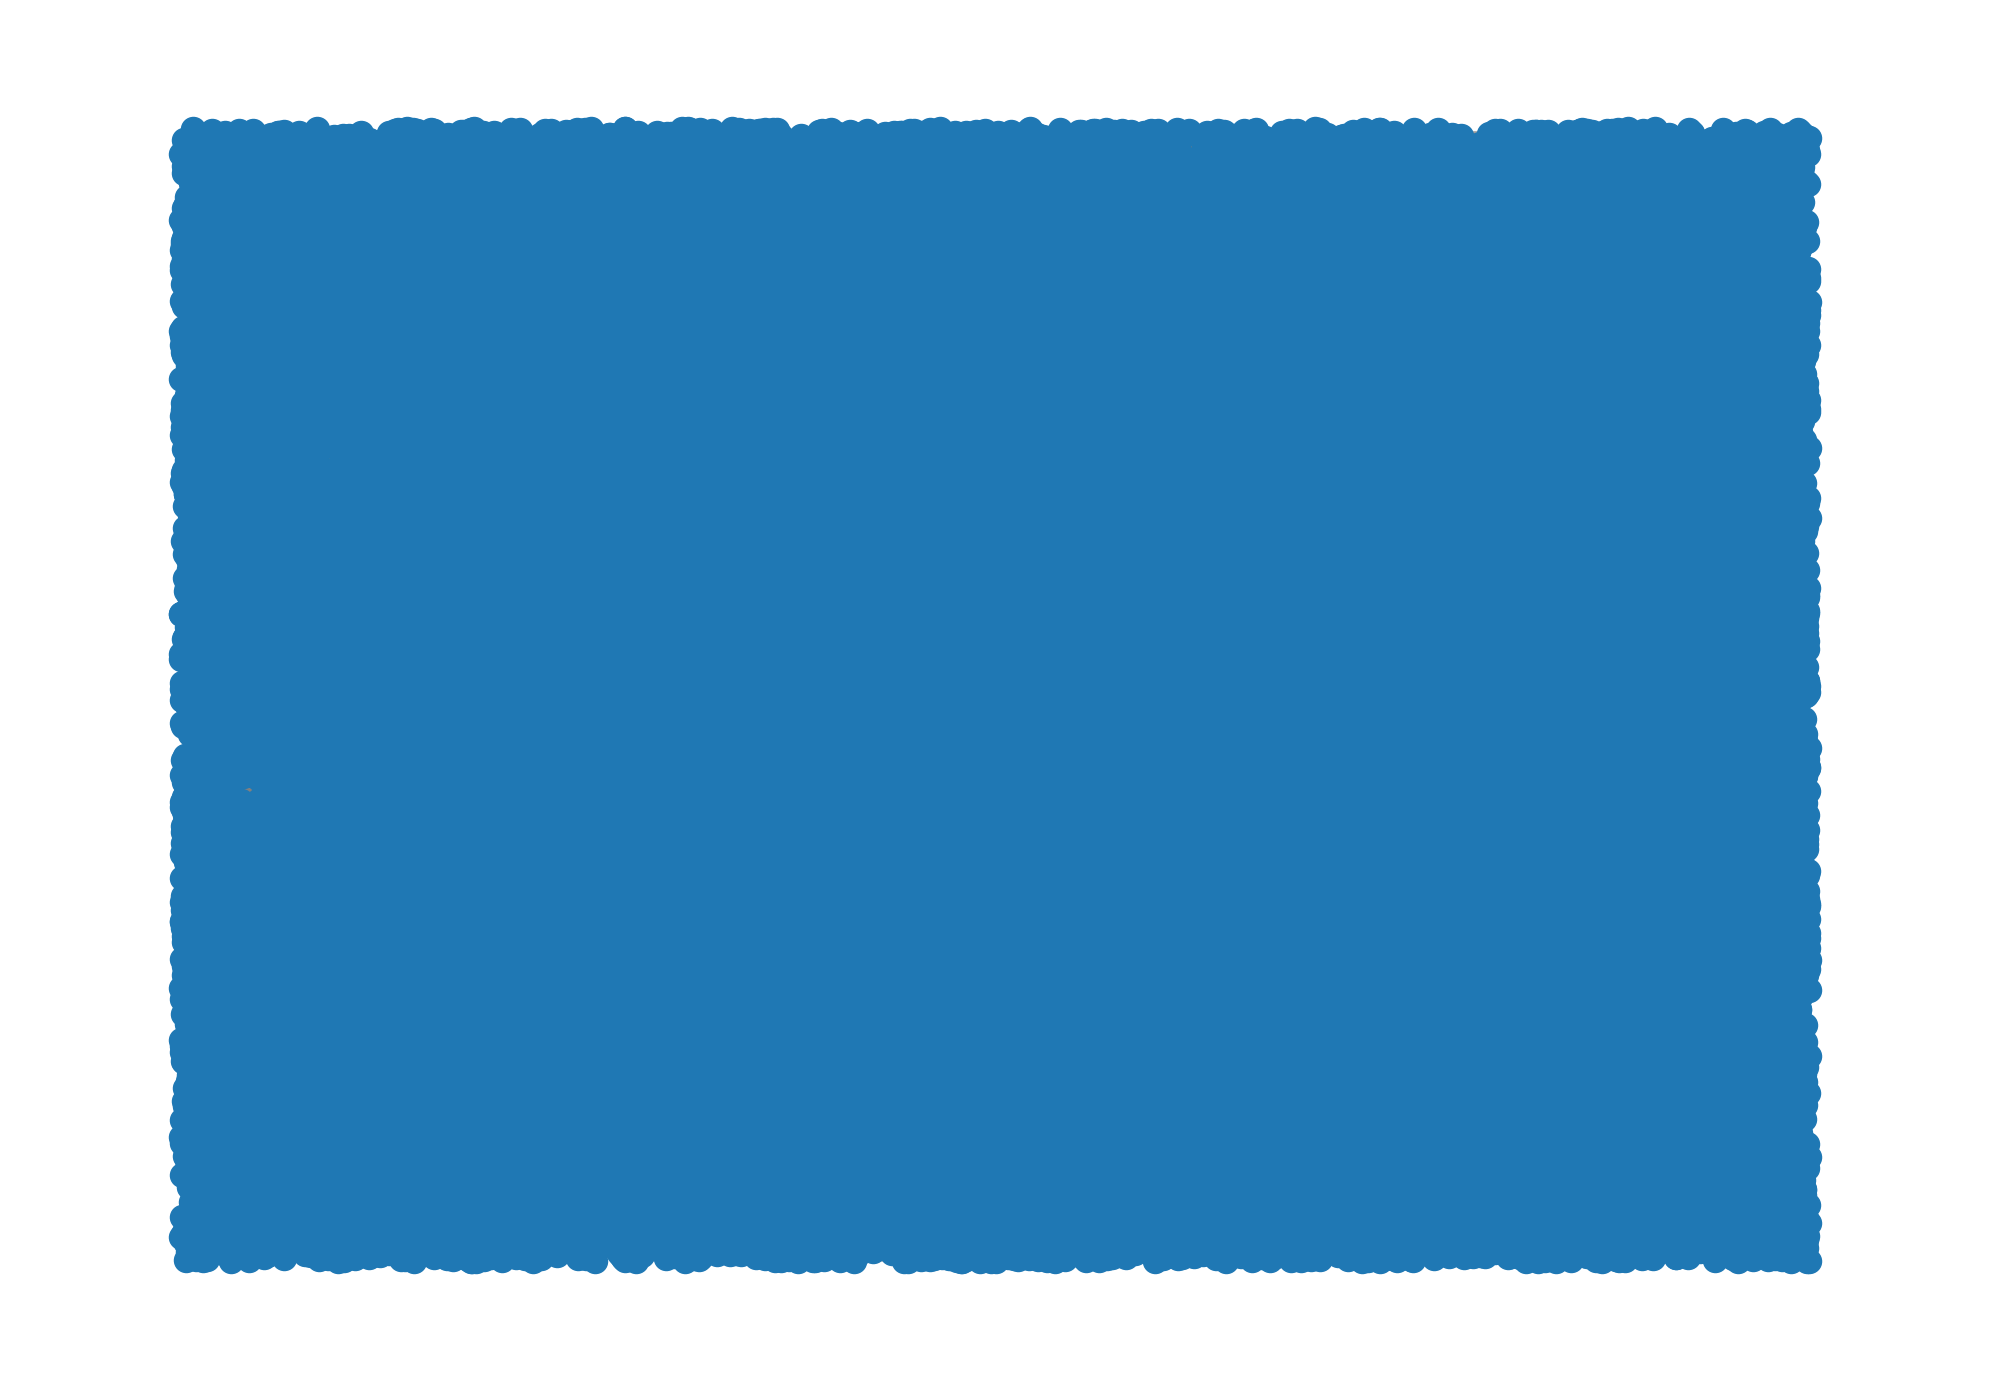

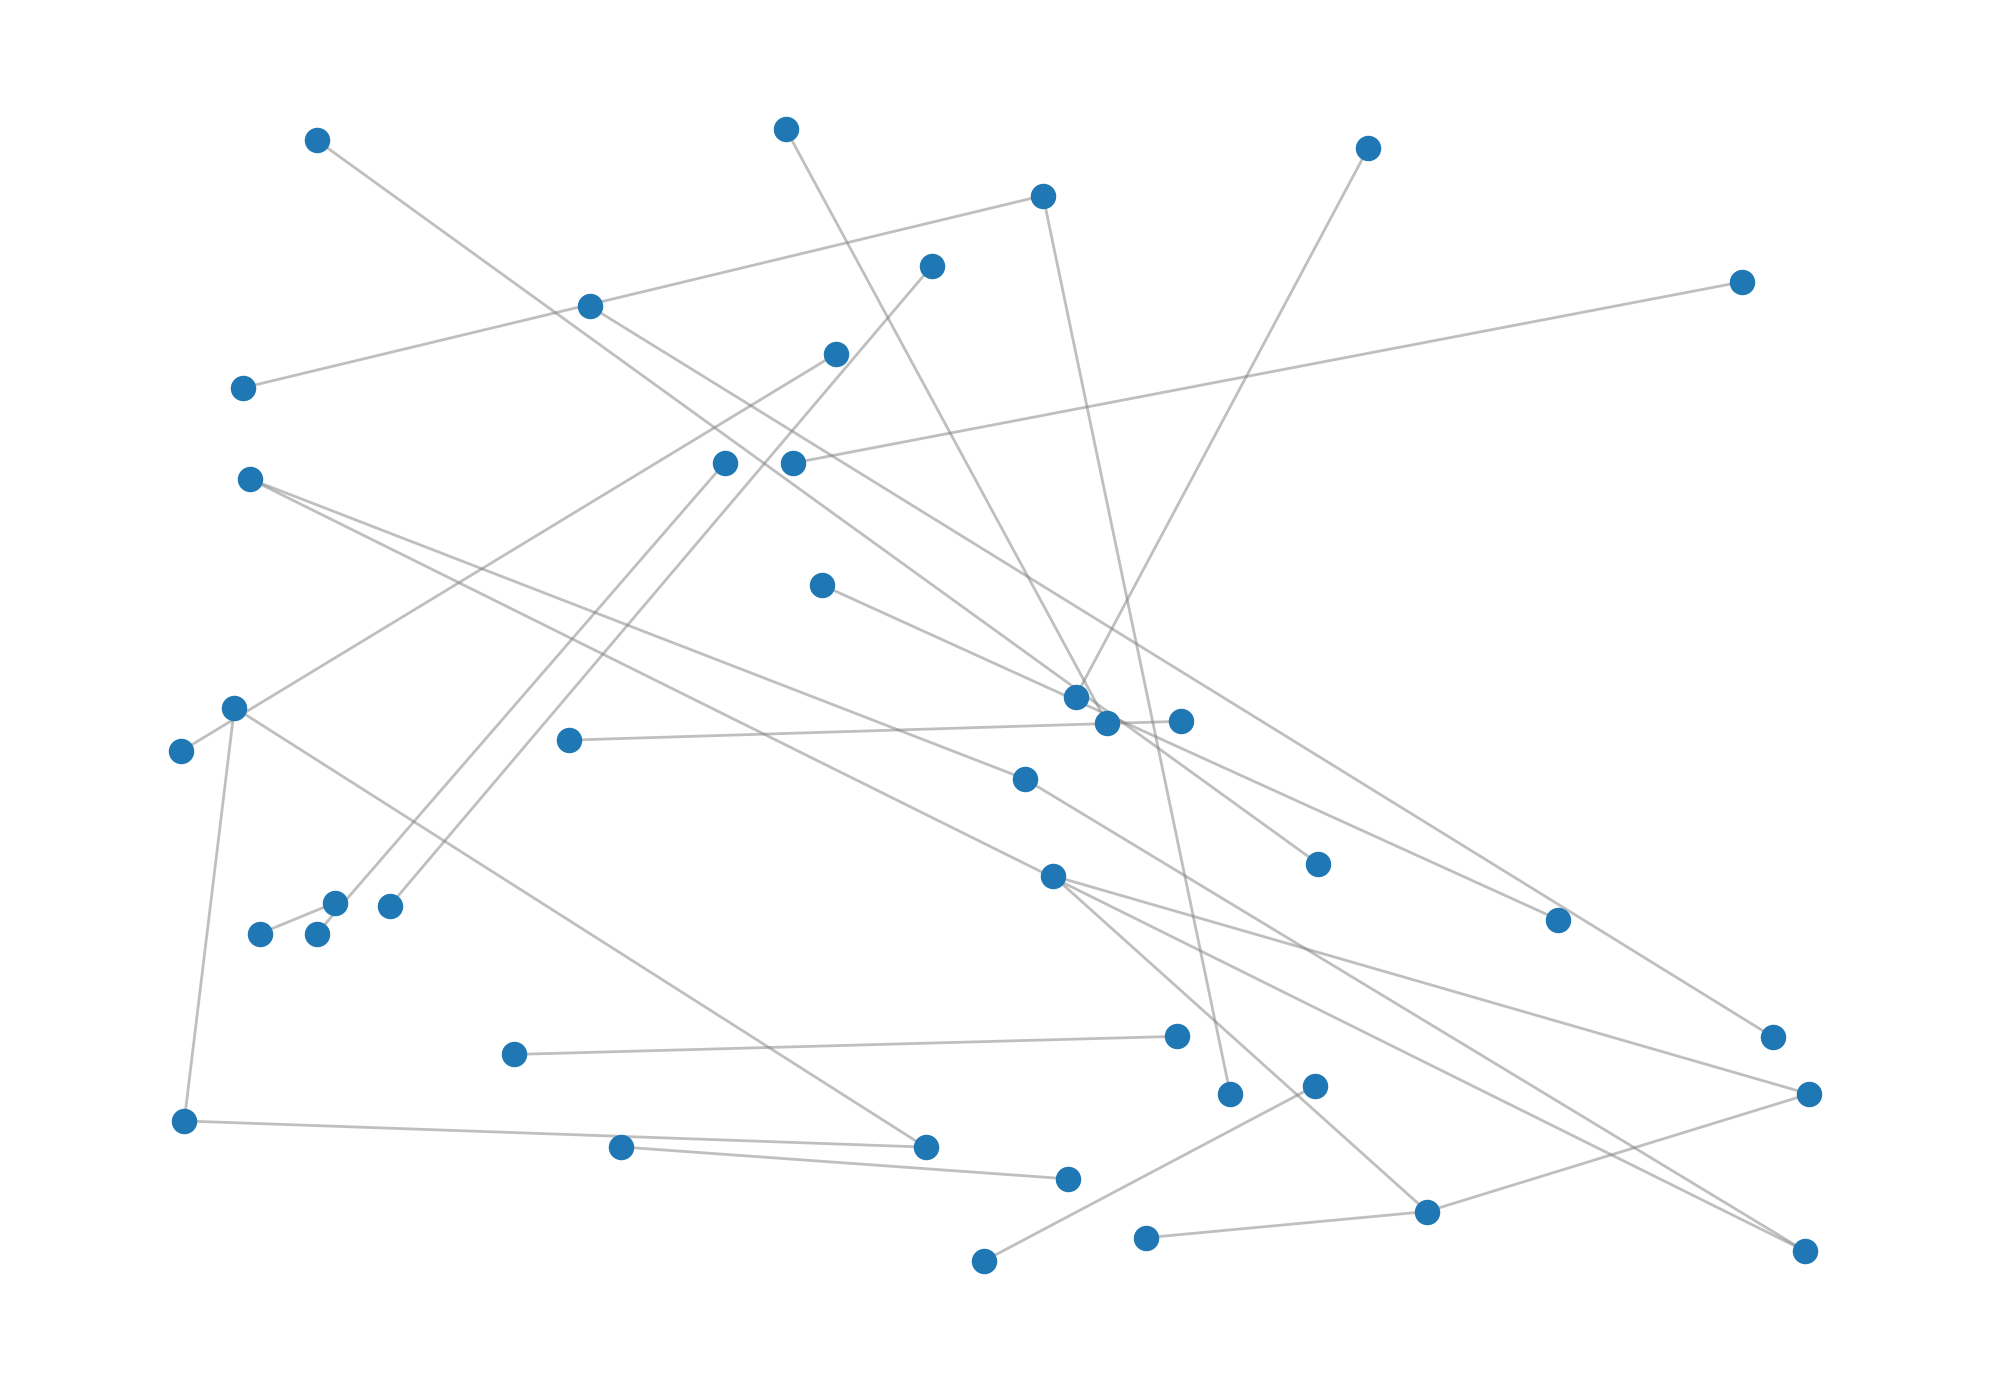

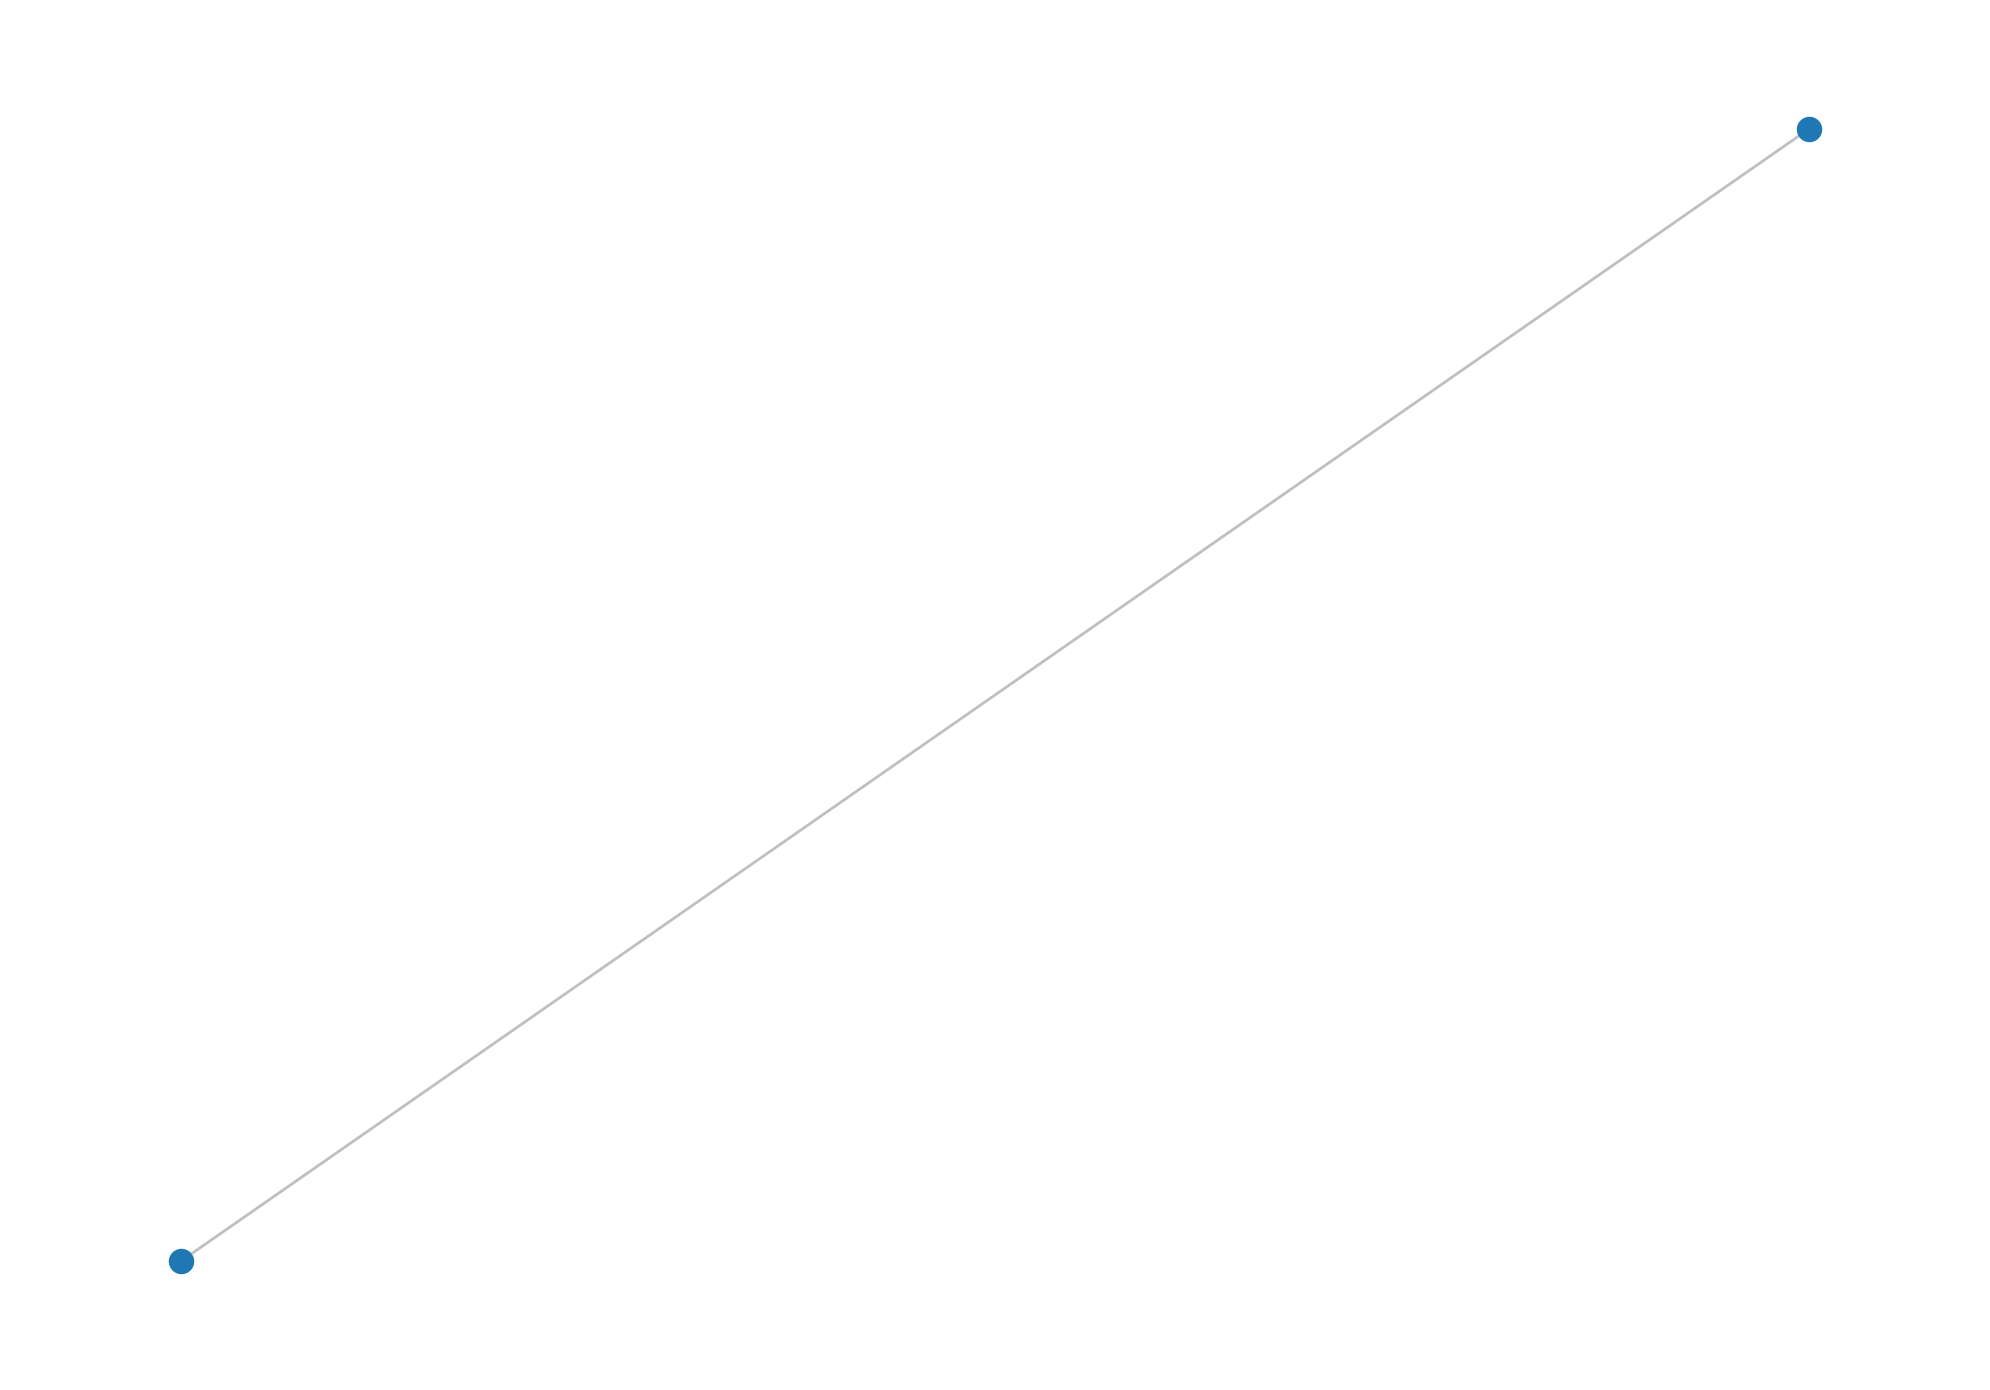

In [48]:
for i in range(3):
  subgraph = island_papers[i][1]
  # set figure size
  plt.figure(figsize=(20,14))
  # determine the positions using spring layout
  pos = nx.random_layout(subgraph)
  nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
      alpha=0.5,width=2)


  # nx.draw(g,pos)
  nx.draw_networkx_nodes(subgraph, pos)
  # set tight layout
  plt.tight_layout()
  # remove axis
  plt.axis('off')

  plt.show()

Once again, we observe a very dense graph at the initial threshold. As the threshold increases, the graphs become smaller. This is a notable distinction compared to the author graphs presented above.

**Conclusion**

Big networks like LMANStat are tough to graph without tricks like the island method. Using it, I found plenty of connections shared authors and collaborations peaking at threshold one. But it’s not a super connected web of papers and authors, more like scattered islands. Cool to see how they link up!

